In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.models import clone_model

In [2]:
data_dir = Path("./captcha_images_v2/")
data_dir2 = Path("./dataset/")
data_dir3 = Path("./captcha_breaker/test")

model_dir = Path("base_model/saved_model")

d1_epochs = 30
d2_epochs = 20
d3_epochs = 20

# Something about CTC? 

In [3]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

# Class structure for handling the datasets

In [4]:
class DataSetHandler():
    def __init__(self,  data_dir,  img_size = (200, 50)):
        pass
        
    def init_calculations(self):
        pass
        
    def print_basics(self):
        pass
    
    # def split_data(images, labels, train_size=0.9, shuffle=True):
    def split_data(self, train_size=0.9, shuffle=True):
        pass

    def encode_single_sample(self, img_path, label):
        pass

    def process_dataset(self, invert_color = False):
        pass

    def plot_examples(self):
        pass
        
    def build_model(self):
        pass
    
    def train_model(self, epochs = 10, early_stopping_patience = 10):
        pass
        
    def make_predictions(self):
        pass


In [5]:
def init(self, data_dir,  img_size = (200, 50), file_name_excluder = ""):
    self.img_width = img_size[0]
    self.img_height = img_size[1]
    self.data_dir = data_dir;
    
    self.invert_color = False
    self.batch_size = 16
    self.downsample_factor = 4
    self.init_calculations(file_name_excluder)

# explain yada yada
def init_calculations(self, file_name_excluder):
    
    self.images = sorted(list(map(str, list(self.data_dir.glob("*.png")))))
    self.labels = [img.split(os.path.sep)[-1].split(file_name_excluder + ".png")[0] for img in self.images]
    
    self.max_length = max([len(label) for label in self.labels])
    
    characters = set(char for label in self.labels for char in label)
    self.characters = sorted(list(characters))

    self.char_to_num = layers.StringLookup(
        vocabulary=list(self.characters), mask_token=None
    )
        
    # Mapping integers back to original characters
    self.num_to_char = layers.StringLookup(
        vocabulary=self.char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

DataSetHandler.__init__ = init
DataSetHandler.init_calculations = init_calculations

data1 = DataSetHandler(data_dir = data_dir)

In [6]:

# explain
def print_basics(self):
    print("Number of images found: ", len(self.images))
    print("Number of labels found: ", len(self.labels))
    print("Number of unique characters: ", len(self.characters))
    print("Characters present: ", self.characters)    
    
DataSetHandler.print_basics = print_basics

data1.print_basics()

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## Splitting data

In [7]:
def split_data(self, train_size=0.7, validation_size=0.2, shuffle=True):
    # 1. Get the total size of the dataset
    images = np.array(self.images)
    labels = np.array(self.labels)
    size = len(self.images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training and validation samples
    train_samples = int(size * train_size)
    validation_samples = int(size * validation_size)
    # 4. Split data into training, validation, and test sets
    self.x_train, self.y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    self.x_valid, self.y_valid = images[indices[train_samples:(train_samples + validation_samples)]], labels[indices[train_samples:(train_samples + validation_samples)]]
    self.x_test, self.y_test = images[indices[(train_samples + validation_samples):]], labels[indices[(train_samples + validation_samples):]]
    return self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test

DataSetHandler.split_data = split_data

data1.split_data();

## Data preprocessing

In [8]:
def encode_single_sample(self, img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [self.img_height, self.img_width])
    
    if (self.invert_color):
        # Inverting color
        img = 1- img
    
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

DataSetHandler.encode_single_sample = encode_single_sample

In [9]:
def process_dataset(self, invert_color = False):
    self.invert_color = invert_color
    train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
    self.train_dataset = (
        train_dataset.map(
            # self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    validation_dataset = tf.data.Dataset.from_tensor_slices((self.x_valid, self.y_valid))
    self.validation_dataset = (
        validation_dataset.map(
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    test_dataset = tf.data.Dataset.from_tensor_slices((self.x_test, self.y_test))
    self.test_dataset = (
        test_dataset.map(
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    return (self.train_dataset, self.validation_dataset, self.test_dataset)

DataSetHandler.process_dataset = process_dataset

data1.process_dataset();

## plotting examples

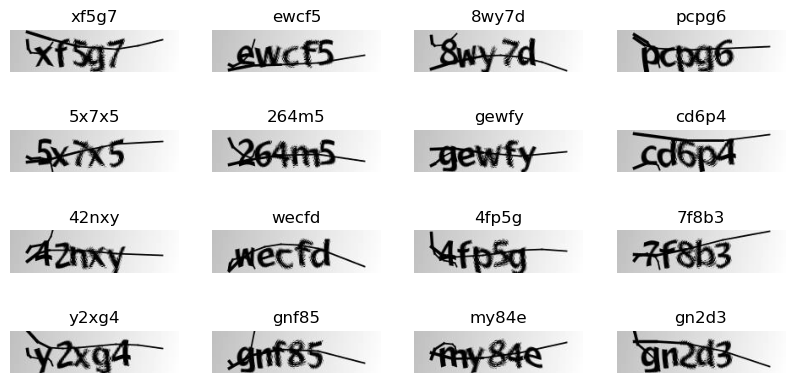

In [10]:
def plot_examples(self):
    _, ax = plt.subplots(4, 4, figsize=(10, 5))
    for batch in self.train_dataset.take(1):
        images = batch["image"]
        labels = batch["label"]
        for i in range(16):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(self.num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // 4, i % 4].set_title(label)
            ax[i // 4, i % 4].axis("off")
    plt.show()
    
DataSetHandler.plot_examples = plot_examples

data1.plot_examples()

## Defining a base model for the first dataset

In [11]:
def base_model_1(dataset_handler):
    # Inputs to the model
    input_img = layers.Input(
        shape=(dataset_handler.img_width, dataset_handler.img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((dataset_handler.img_width // 4), (dataset_handler.img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25), name = "bidirectional1")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25, name = "bidirectional2"))(x)

    # Output layer
    x = layers.Dense(
        len(dataset_handler.char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
        # 50, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    dataset_handler.model = model
    return model

In [12]:
# data1.build_model = base_model_1
# model1 = data1.build_model(data1);
model1 = base_model_1(data1)
model1.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

## training model

In [13]:
def train_model(self, epochs = 10, early_stopping_patience = 10, model = None):
    # epochs = 10
    # early_stopping_patience = 10
    # Add early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )

    # Allowing to change on a model not defined for the dataset
    if (model):
        model_to_fit = model
    else: 
        model_to_fit = self.model
        
    
    # Train the model
    self.history = model_to_fit.fit(
        self.train_dataset,
        validation_data=self.validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
    )

DataSetHandler.train_model = train_model

data1.train_model(epochs = d1_epochs)
# data1.train_model(epochs = 30)



Epoch 1/30
46/46 [==============================] - 9s 94ms/step - loss: 21.1432 - val_loss: 16.4031
Epoch 2/30
46/46 [==============================] - 3s 66ms/step - loss: 16.3604 - val_loss: 16.3918
Epoch 3/30
46/46 [==============================] - 3s 69ms/step - loss: 16.3488 - val_loss: 16.3928
Epoch 4/30
46/46 [==============================] - 3s 70ms/step - loss: 16.3460 - val_loss: 16.3914
Epoch 5/30
46/46 [==============================] - 3s 68ms/step - loss: 16.3359 - val_loss: 16.3946
Epoch 6/30
46/46 [==============================] - 3s 68ms/step - loss: 16.3350 - val_loss: 16.3890
Epoch 7/30
46/46 [==============================] - 3s 67ms/step - loss: 16.3294 - val_loss: 16.3886
Epoch 8/30
46/46 [==============================] - 3s 68ms/step - loss: 16.3197 - val_loss: 16.3847
Epoch 9/30
46/46 [==============================] - 3s 68ms/step - loss: 16.3209 - val_loss: 16.3804
Epoch 10/30
46/46 [==============================] - 3s 68ms/step - loss: 16.3087 - val_los

## Making predictions

1/1 [==============================] - 1s 897ms/step


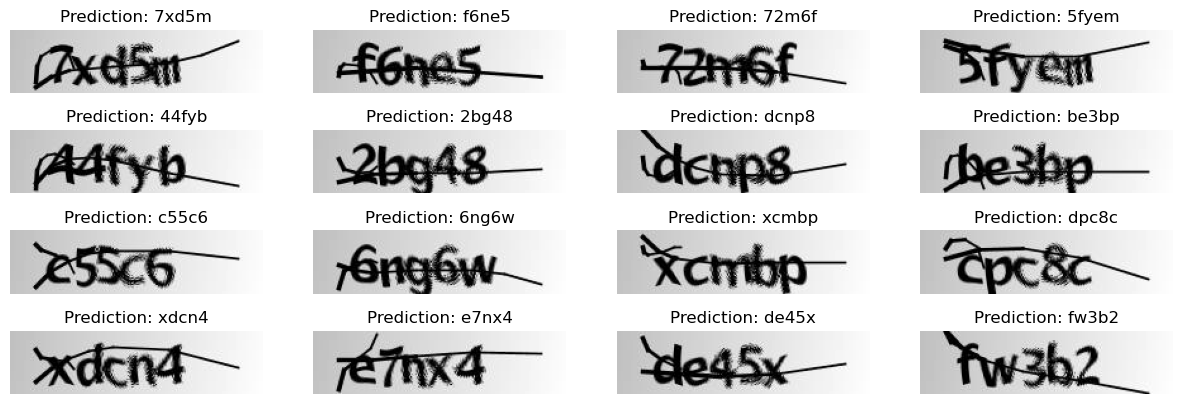

In [14]:

        
def make_predictions(self, model = None):
    
    if (model == None):
        _model = self.model
    else: 
        _model = model;
    # Get the prediction model by extracting layers till the output layer
    prediction_model = keras.models.Model(
        _model.get_layer(name="image").input, _model.get_layer(name="dense2").output
        # _model.get_layer(name="image").input, _model.get_layer(name="ctc_loss").output
    )
    # prediction_model.summary()

    # A utility function to decode the output of the network
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        
        # Use greedy search. For complex tasks, you can use beam search
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length
        ]
        # Iterate over the results and get back the text
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text


    #  Let's check results on some validation samples
    for batch in self.test_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(self.num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        _, ax = plt.subplots(4, 4, figsize=(15, 5))
        for i in range(len(pred_texts)):
            img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
            img = img.T
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    plt.show()
    
DataSetHandler.make_predictions = make_predictions

data1.make_predictions()

# saving model

In [15]:

model1.save(model_dir) 
plot_model(model1, to_file = "base_model/base_model.png")


KeyboardInterrupt: 

# Loading model

In [ ]:

loaded_model = tf.keras.models.load_model(dir)

In [ ]:
loaded_base_model = keras.models.Model(
    loaded_model.get_layer(name="image").input, loaded_model.get_layer(name="dense2").output
)
loaded_base_model.summary()

# **Second dataset**

## process data and show example

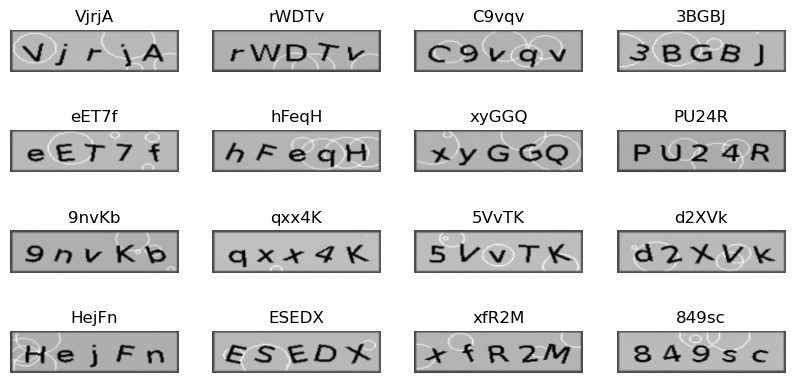

Number of images found:  3016
Number of labels found:  3016
Number of unique characters:  51
Characters present:  ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'h', 'j', 'k', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [17]:
data2 = DataSetHandler(data_dir2)
data2.split_data();
data2.process_dataset(invert_color = True);
data2.plot_examples()
data2.print_basics()

# Defining the second model which uses transfer learning

In [ ]:
def second_model(self, base_model = None):
    # Inputs to the model
    input_img = layers.Input(
        shape=(self.img_width, self.img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    base_model = keras.models.clone_model(base_model)
    base = keras.models.Model(
        base_model.get_layer(name="Conv1").input, base_model.get_layer(name="bidirectional1").output
    )
    # base.trainable = False
    x = base(input_img, name = "base_model")
    # x = base(input_img, training = False)
    
    
    
     # Output layer
    x = layers.Dense(
        len(self.char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)
    
    
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)
    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    self.model = model
    return model

##  Building and training model with the same architecture as the base model

In [ ]:
first_d2 = base_model_1(data2)
data2.model.summary()
data2.train_model(model = first_d2, epochs = d2_epochs)

# Using the base model trained with the first dataset

In [ ]:
model2 = data2.second_model(data2, base_model = loaded_base_model);
model2.summary()

In [ ]:
data2.train_model(epochs = d2_epochs, model = model2)

# Third dataset

In [ ]:
data3 = DataSetHandler(data_dir3, file_name_excluder="_1")
data3.split_data();
data3.process_dataset();
data3.plot_examples()

In [ ]:
data3.build_model = second_model(data3, loaded_base_model)

In [ ]:
data3.train_model(epochs = d3_epochs)

In [ ]:
data3.make_predictions()

In [ ]:
data3.make_predictions(data2.model)


## Train on top of model 1  

In [ ]:
# transfered_model = second_model(data2, base_model = data1.model)

In [ ]:
# data2.train_model(epochs = d2_epochs, model = transfered_model)

In [ ]:
# data2.make_predictions(model = transfered_model)